 # California Housing 회귀 분석 캡스톤

우리가 집을 살 때 보는 가격은 정말로 “공정한” 가격일까?
1990년 캘리포니아 인구조사 기반 데이터를 보면, 같은 지역이어도 가구 소득에 따라 집값이 얼마나 달라질까? 

집의 나이, 방의 수, 인구밀도는 정말 중요할까?

이번 캡스톤 과제에서는 California Housing 데이터셋을 활용하여 지리적 위치·가구 소득·주택 특성이 주택 중위 가격을 어떤 구조로 설명하는지를 데이터와 회귀모형을 통해 단계적으로 탐구합니다.

이 과제의 목표는 예측 정확도를 높이는 것이 아니라, “캘리포니아 주택 가격은 어떤 논리와 불평등으로 형성되는가”를
수치와 언어로 설명하는 것입니다.

### 라이브러리 참조

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
import pingouin as pg

# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


from statannotations.Annotator import Annotator

# 로지스틱을 위한 참조
import statsmodels.api as sm

from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)



# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell



import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

### 데이터 불러오기

In [2]:
origin = load_data('california_housing')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/kaggle/california_housing.xlsx
[desc] 1990년 미국 인구조사(Census)를 기반으로 캘리포니아 각 지역의 인구·주택·소득 특성과 주택 중위가격을 담아, 회귀 분석과 머신러닝 모델 실습에 널리 사용되는 대표적인 주택 가격 데이터 (출처: https://www.kaggle.com/datasets/camnugent/california-housing-prices)

field               description
------------------  ------------------------------------------------------------------------------
longitude           경도(Longitude). 서경(–값) 기준.
latitude            위도(Latitude). 북위(+) 기준.
housing_median_age  해당 구역(블록 그룹)의 주택 중위 연령(년).
total_rooms         구역 내 모든 주택의 총 방(room) 수 합계.
total_bedrooms      구역 내 모든 주택의 총 침실(bedroom) 수 합계.
population          구역의 전체 인구 수.
households          구역의 전체 “가구 수”(living units).
median_income       구역의 중위 소득(median income), 단위는 약 1 = $10,000 수준.
median_house_value  주택 중위가격(달러). 회귀의 목표변수(타깃).
ocean_proximity     해안과의 거리/접근성 범주: <1H OCEAN, INLAND, NEAR BAY, NEAR OCEAN, ISLAND 등.


==== 데이터 크기 확인 ====
데이터셋 크기: (20640, 10)
열 개수: 10
행 개수: 20640

==== 타입확인 ====
<class 'pand

In [35]:
origin.head(100)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
95,-122.26,37.80,36,5329,2477.0,3469,2323,2.0096,130000,NEAR BAY
96,-122.26,37.82,31,4596,1331.0,2048,1180,2.8345,183800,NEAR BAY
97,-122.26,37.81,29,335,107.0,202,91,2.0062,125000,NEAR BAY
98,-122.26,37.82,22,3682,1270.0,2024,1250,1.2185,170000,NEAR BAY


### 미션 1. 이 데이터는 믿을만 할까?

1. 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.
2. MedHouseValue가 0이거나 극단값인지, MedInc/HouseAge/AveRooms 등 주요 변수의 범위가 현실적인지 확인한다.

3. 1940년 이전 건축 주택이 52로 코딩되는 이유를 이해하고, 분석에 미칠 영향을 검토한다.
4. 전처리 전·후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만든다.
 
* MedHouseValue는 실제 달러 단위입니다. 1990년 명목가를 참고해 현실성을 평가하세요.

#### 결측치/이상치/편향 점검

1. 파생변수 추가 생성

| 변수명 (Variable) | 계산 수식 (Formula) | 생성 의도 및 의미 (Description) |
| :--- | :--- | :--- |
| **`rooms_per_household`**<br>(가구당 방 개수) | `total_rooms` / `households` | **주택의 규모(Size) 파악**<br>단순 방 개수가 아닌, 한 가구가 사용하는 평균적인 방의 개수를 통해 집의 평수를 가늠 |
| **`bedrooms_per_room`**<br>(방 하나당 침실 비율) | `total_bedrooms` / `total_rooms` | **주택의 구조(Structure) 파악**<br>전체 방 중 침실이 차지하는 비중을 통해 일반 주거용인지, 특수 목적 시설인지 구분 |
| **`population_per_household`**<br>(가구당 인원수) | `population` / `households` | **거주 밀도(Density) 파악**<br>한 집에 몇 명이 사는지를 파악하여 1인 가구 지역인지, 다인 가구 밀집 지역인지 확인 |



3. 파생변수 기반 데이터 추가 전처리
   
| 구분 | 제거 대상 / 조건 | 개수 (비중) | 제거 사유 (Reasoning) |
| :--- | :--- | :--- | :--- |
| **결측치**<br>(Missing Value) | `total_bedrooms` is **Null** | 207개 (약 1.0%) | **데이터 누락**<br>전체 데이터 대비 비중이 매우 작아, 중앙값 대치 대신 단순 삭제(`dropna`) 처리 |
| **이상치**<br>(Outlier 1) | `rooms_per_household` **$\ge$ 100** | 극소수 | **비정상적 규모**<br>한 가구에 방이 100개 이상인 경우는 호텔이나 기숙사 등 특수 시설로 의심됨 |
| **이상치**<br>(Outlier 2) | `bedrooms_per_room` **$\ge$ 0.8** | 극소수 | **구조적 오류**<br>집 전체 방의 80% 이상이 침실인 경우는 일반적인 주택 구조로 보기 힘든 기입 오류 가능성 |
| **이상치**<br>(Outlier 3) | `population_per_household` **$\ge$ 100** | 극소수 | **비정상적 밀도**<br>한 집에 30명 이상 거주하는 경우는 셰어하우스, 군부대나 수용 시설 등으로 판단되어 분석에서 제외 |

### 1940년 이전 건축 주택이 52로 코딩되는 이유를 이해하고, 분석에 미칠 영향을 검토한다.

1. 현상 및 원인: 히스토그램의 52 구간 급증은 데이터 수집 당시(1990년), 1940년 이전(50년 이상) 건축된 주택을 모두 52로 일괄 처리(Right-Censoring)했기 때문입니다.

2. 영향: 52년 된 집과 100년 된 고택을 구분할 수 없어, 건축 연도에 따른 세밀한 가격 차이를 반영하는 데 한계가 있습니다.

3. 조치 결과: 유지 (Keep)
타겟(집값)이 아닌 설명 변수이므로 왜곡 위험이 상대적으로 적다고 판단했습니다.
삭제 시 전체 데이터의 상당수가 유실되므로, 해당 값을 '오래된 주택 밀집 지역'을 나타내는 범주적 특성으로 이해하고 사용합니다.

In [4]:
empty = origin.isnull()
empty.sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [11]:
# 'total_bedrooms' 열이 비어있는(NaN) 행만 찾아서 제거합니다.
df_clean=origin.copy()
df_clean_complete = df_clean.dropna(subset=['total_bedrooms'])

# 제거 후 확인 (데이터 개수가 207개 줄었는지 확인)
print(f"제거 전: {len(origin)}개")
print(f"제거 후: {len(df_clean_complete)}개")

제거 전: 20640개
제거 후: 20433개


<추가 지표 생성>

In [ ]:
df_add_new = df_clean_complete.copy()

# 파생 변수 생성 (Feature Engineering)
# 1. 가구당 방 개수 (Rooms per Household)
df_add_new['rooms_per_household'] = df_add_new['total_rooms'] / df_add_new['households']

# 2. 방 하나당 침실 개수 (Bedrooms per Room) 
df_add_new['bedrooms_per_room'] = df_add_new['total_bedrooms'] / df_add_new['total_rooms']

# 3. 가구당 인구수 (Population per Household)
df_add_new['population_per_household'] = df_add_new['population'] / df_add_new['households']


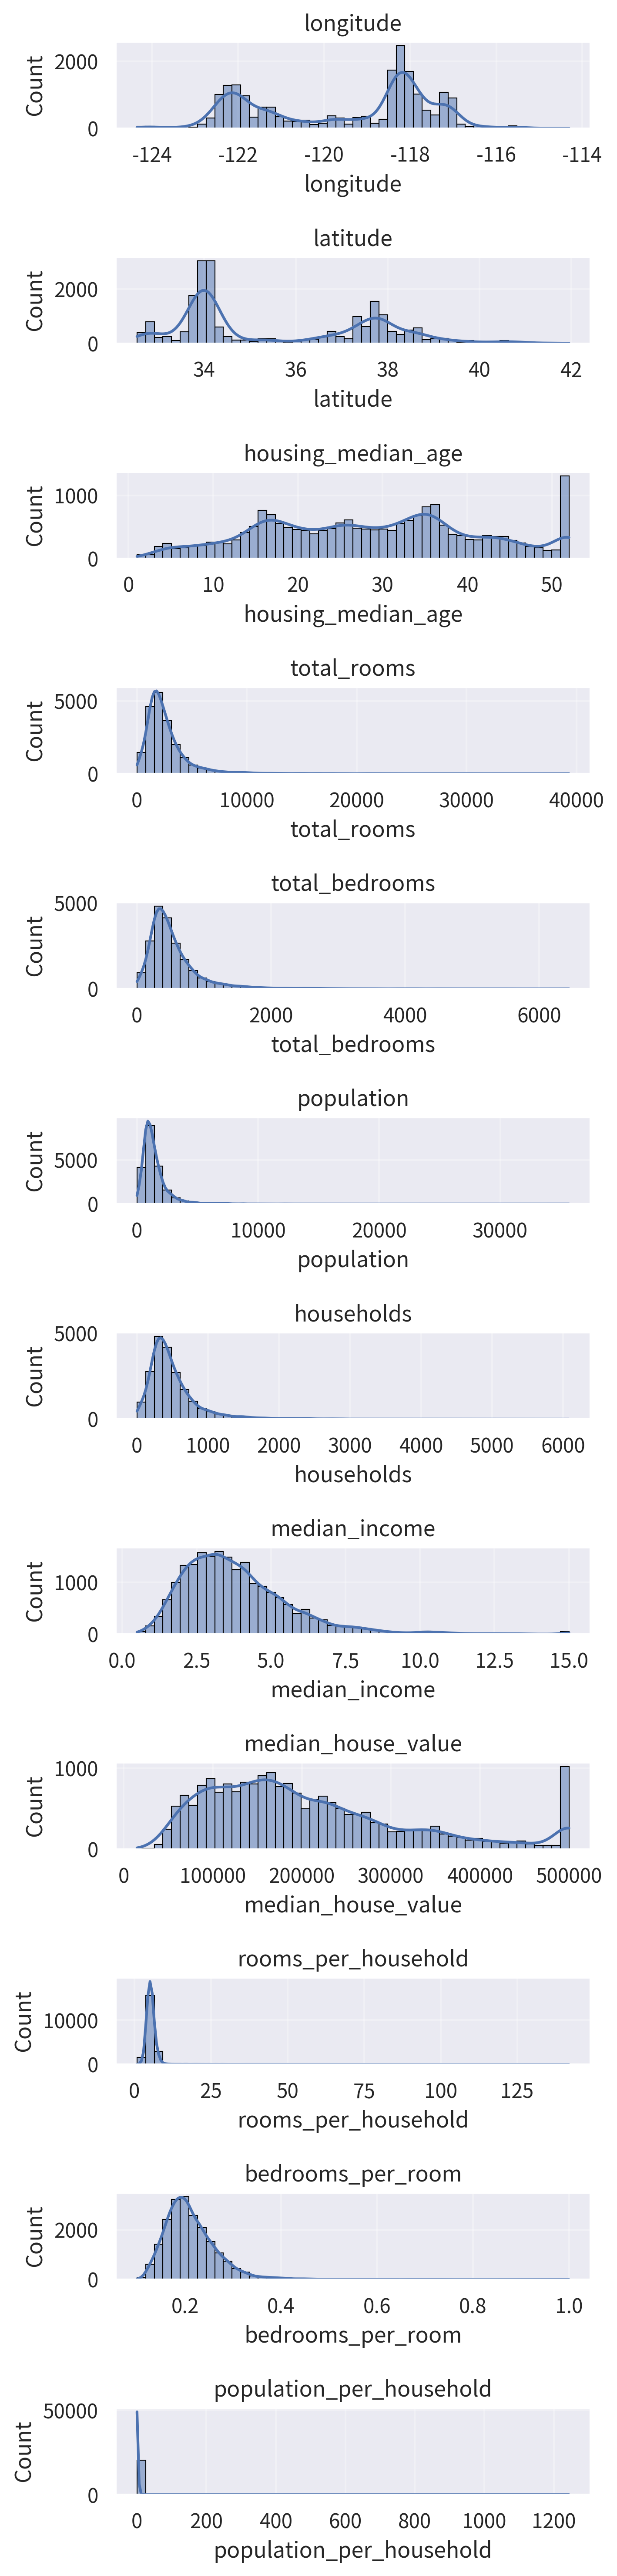

In [36]:
# 히스토그램으로 보고 싶은 컬럼 7개
cols_list = ["longitude", "latitude", "housing_median_age", "total_rooms",
             "total_bedrooms", "population", "households",'median_income','median_house_value','rooms_per_household','bedrooms_per_room','population_per_household']
my_dpi = 300
# 1) 그래프 초기화

width_px = 1500
height_px = 6000
rows = 12
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Histogram 그리기
for i, col in enumerate(cols_list):
    sb.histplot(
        data=df_add_new,
        x=col,
        bins=50,
        kde=True,
        edgecolor="#000000",
        linewidth=0.5,
        ax=ax[i]              # ⭐ 핵심
    )
    ax[i].set_title(col)
    ax[i].grid(alpha=0.3)

# 3) 출력
plt.tight_layout()
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()
plt.close()


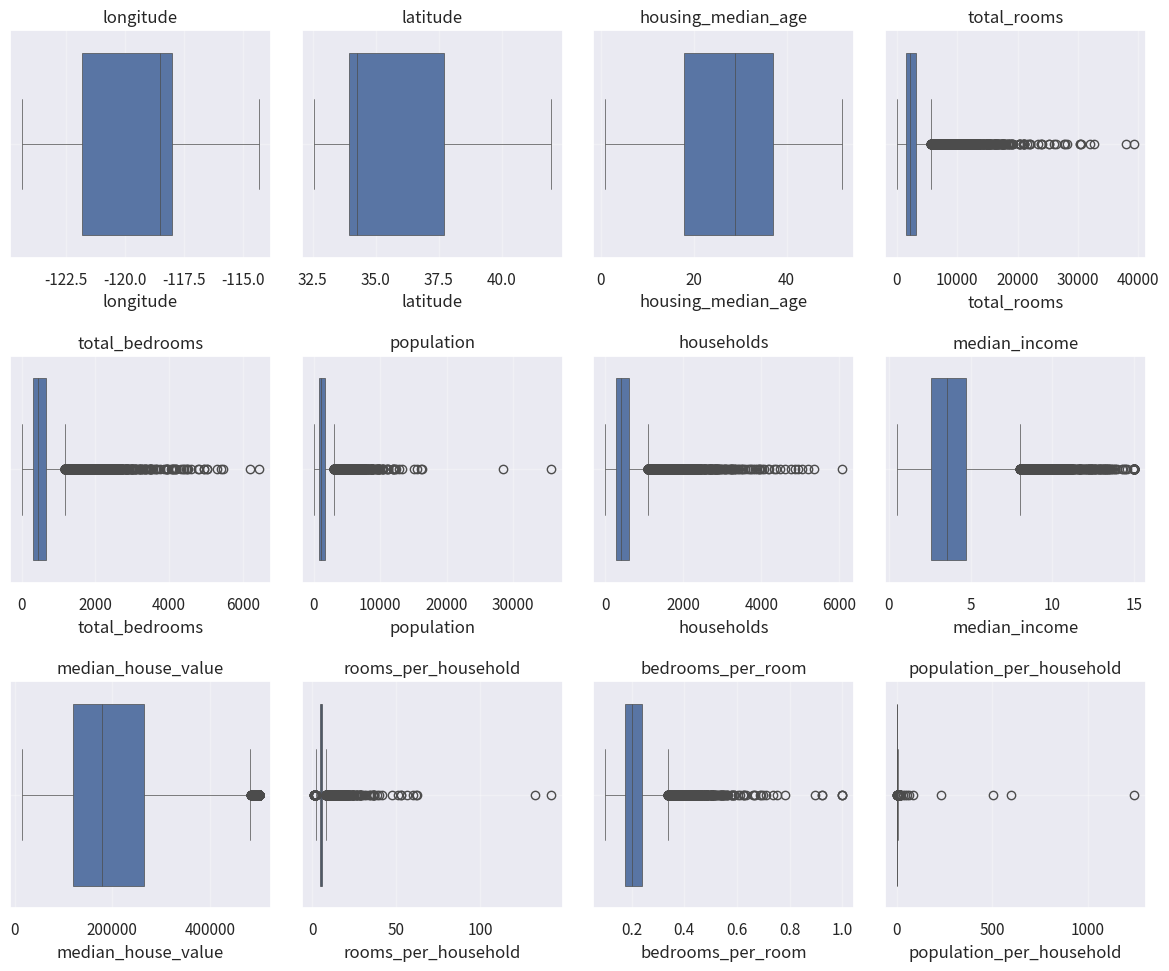

In [27]:
import matplotlib.pyplot as plt
import seaborn as sb

# 보고 싶은 컬럼 9개 (리스트에 9개가 들어있습니다)
cols_list = ["longitude", "latitude", "housing_median_age", "total_rooms",
             "total_bedrooms", "population", "households",'median_income','median_house_value','rooms_per_household','bedrooms_per_room','population_per_household']

my_dpi = 100  # 모니터 확인용으로는 100~150 정도가 적당합니다.

# 1) 그래프 초기화 (3행 3열)
width_px = 1200
height_px = 1000
rows = 3
cols = 4
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2D 배열인 ax를 1D로 펴주면 반복문 돌리기 편합니다.
axes_flat = ax.flatten()

# 2) Boxplot 그리기
for i, col in enumerate(cols_list):
    sb.boxplot(
        data=df_add_new, # 사용하시는 데이터프레임 이름
        x=col,
        linewidth=0.5,
        ax=axes_flat[i]       # ⭐ 핵심: 평평하게 펴진 축(axis) 사용
    )
    axes_flat[i].set_title(col, fontsize=12, fontweight='bold')
    axes_flat[i].grid(alpha=0.3)

# 3) 출력 및 여백 조정
plt.tight_layout()
plt.show()

In [34]:
df_add_new_ourlier_remove = df_add_new.copy()

# 1. 이상치 조건 정의 (제거 대상)
outlier_condition = (
    (df_add_new_ourlier_remove['rooms_per_household'] >= 100) |
    (df_add_new_ourlier_remove['bedrooms_per_room'] >= 0.8) |
    (df_add_new_ourlier_remove['population_per_household'] >= 30)
)

# 2. 몇 개나 되는지 확인
outlier_count = df_add_new_ourlier_remove[outlier_condition].shape[0]
print(f"제거될 이상치 데이터 개수: {outlier_count}개")

# 3. 이상치가 아닌 정상 데이터만 남기기 (~)
# 물결표(~)는 '반대(not)'를 의미합니다. 즉, 이상치가 '아닌' 것만 선택합니다.
df_remove_new = df_add_new_ourlier_remove[~outlier_condition].copy()

print(f"정제 후 남은 데이터 개수: {len(df_final)}개")

제거될 이상치 데이터 개수: 17개
정제 후 남은 데이터 개수: 20421개


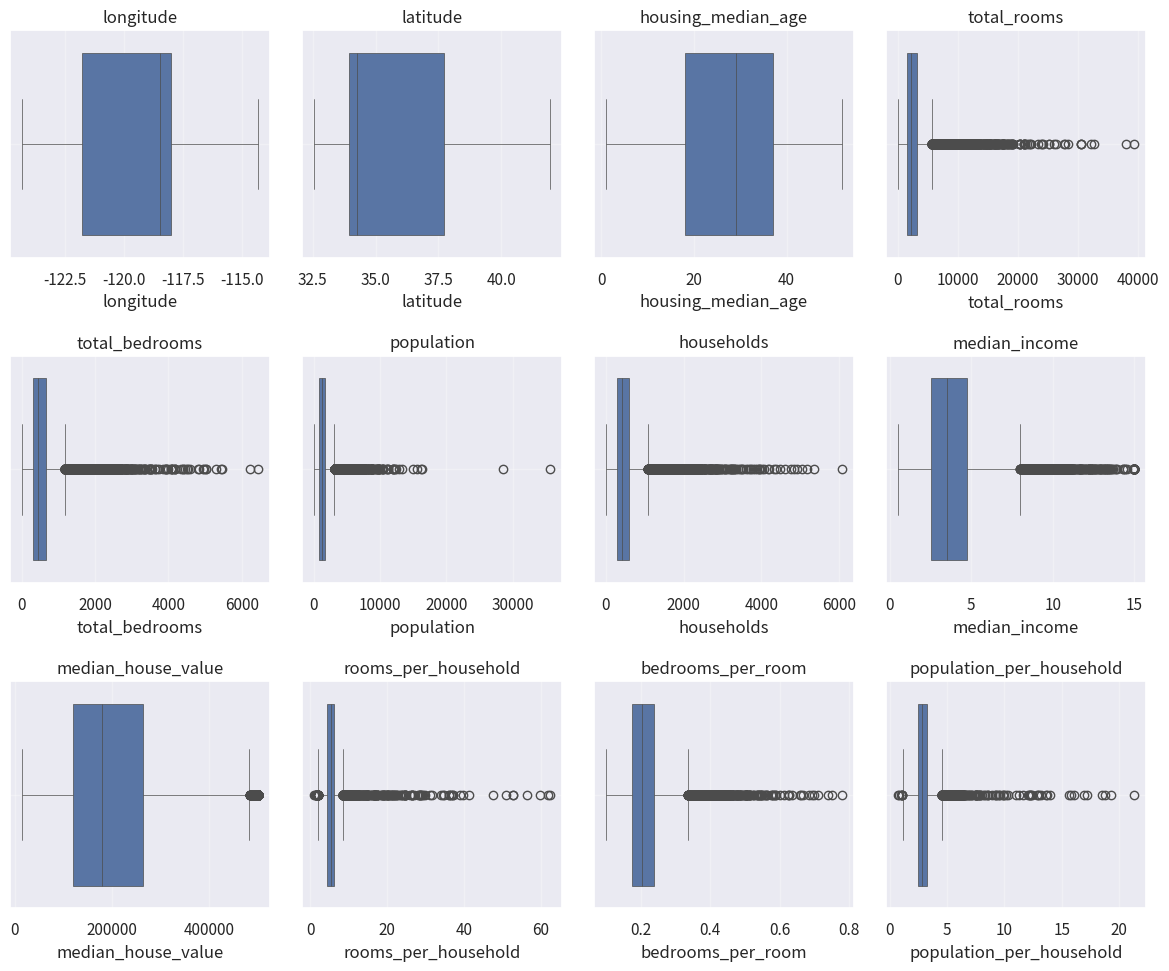

In [33]:
import matplotlib.pyplot as plt
import seaborn as sb

# 보고 싶은 컬럼 9개 (리스트에 9개가 들어있습니다)
cols_list = ["longitude", "latitude", "housing_median_age", "total_rooms",
             "total_bedrooms", "population", "households",'median_income','median_house_value','rooms_per_household','bedrooms_per_room','population_per_household']

my_dpi = 100  # 모니터 확인용으로는 100~150 정도가 적당합니다.

# 1) 그래프 초기화 (3행 3열)
width_px = 1200
height_px = 1000
rows = 3
cols = 4
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2D 배열인 ax를 1D로 펴주면 반복문 돌리기 편합니다.
axes_flat = ax.flatten()

# 2) Boxplot 그리기
for i, col in enumerate(cols_list):
    sb.boxplot(
        data=df_remove_new, # 사용하시는 데이터프레임 이름
        x=col,
        linewidth=0.5,
        ax=axes_flat[i]       # ⭐ 핵심: 평평하게 펴진 축(axis) 사용
    )
    axes_flat[i].set_title(col, fontsize=12, fontweight='bold')
    axes_flat[i].grid(alpha=0.3)

# 3) 출력 및 여백 조정
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd

# 점검할 주요 변수들
cols_to_check = ['median_house_value', 'median_income', 'housing_median_age', 'rooms_per_household']

print("=== 1. 기초 통계량 확인 (Min/Max에 주목하세요) ===")
# .T를 붙이면 행/열이 바뀌어 보기가 더 편합니다.
display(df_final[cols_to_check].describe().T)

print("\n=== 2. 집값(MedHouseValue) 정밀 점검 ===")
# 집값이 0원인 데이터가 있는지 확인
zero_price_count = df_final[df_final['median_house_value'] == 0].shape[0]
print(f"집값이 0인 데이터 개수: {zero_price_count}개")

# 집값이 비정상적으로 싼 경우 (예: $10,000 미만) 확인
cheap_houses = df_final[df_final['median_house_value'] < 10000]
print(f"집값이 $10,000 미만인 데이터 개수: {len(cheap_houses)}개")

if len(cheap_houses) > 0:
    print("-> 너무 싼 집이 존재합니다. 데이터를 눈으로 확인해보세요:")
    display(cheap_houses.head())

=== 1. 기초 통계량 확인 (Min/Max에 주목하세요) ===


,count,mean,std,min,25%,50%,75%,max
median_house_value,20421.0,206853.511189,115419.332549,14999.000000,119500.000000,179800.000000,264700.000000,500001.000000
median_income,20421.0,3.871248,1.898781,0.499900,2.564000,3.536500,4.744000,15.000100
housing_median_age,20421.0,28.628569,12.588791,1.000000,18.000000,29.000000,37.000000,52.000000
rooms_per_household,20421.0,5.419424,2.111657,0.888889,4.442424,5.231806,6.052381,62.422222



=== 2. 집값(MedHouseValue) 정밀 점검 ===
집값이 0인 데이터 개수: 0개
집값이 $10,000 미만인 데이터 개수: 0개
